# Tarea 2 

*Eduardo Moreno, Braulio Piña 153058*

Cargando los paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from matplotlib.animation import FuncAnimation
from celluloid import Camera
import time
from random import seed
from random import randrange
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
pip install celluloid

In [ ]:
pip install tabulate

### Lectura y procesamiento de datos

In [2]:
# Lectura de datos
data = sns.load_dataset('iris')
data.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


A continuación se ajustará la categoría a clasificar, la cual será setosa contra el resto.

In [3]:
# Cambiar ajuste de datos para clasificar setosa
data['categoria'] = [1 if x =='setosa' else -1 for x in data['species']] 

### Máquinas de soporte vectorial (SVM) utilizando el método de descenso por gradiente

In [4]:
# Función clasifica
def clasifica(x, y, theta, theta_0):
    """ DEF: Evalúa la predicción de la categoría en base al modelo (theta, theta_0)
    Inputs:
    x: vector de caracteristicas
    y: vector de etiquetas
    theta: vector
    theta_0: escalar
    Outputs:
    value: -1 si la clasific es incorrecta, 0 si lo es
    """
    
    # Regla de clasificación
    z = y*(np.dot(theta,np.transpose(x)) + theta_0)
    if z < 1 :
        value = -1
    else:
        value = 0

    return value

In [5]:
def loess(x, y, theta, theta_0):
    """ DEF: Evaluación en la función de perdida
    Inputs:
    x: vector de características
    y: vector de etiquetas
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    Outputs:
    suma = valor de pérdida  
    """
    
    suma = 0
    H = 0
    n = x.shape[0]
    
    for i in range(n):
        H = y[i]*(np.dot(theta, x[i]) + theta_0)
        if H >= 1:
            suma += 0
        else:
            suma += (1-H)
            
    return suma

In [6]:
def jacob(X, Y, theta, theta_0, lamb):
    """ DEF: Cálculo del jacobiano
    Inputs:
    X: matriz de características
    Y: vector de etiquetas
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    lamb: escalar que indica la tasa de aprendizaje
    Outputs:
    value = valor del jacobiano
    """
    
    n = X.shape[0]
    jacobiano = loess(X, Y, theta, theta_0)/n + (lamb/2.0)*np.linalg.norm(theta)

    return jacobiano

In [7]:
# Función para descenso por gradiente
def SVM(X, Y, theta, theta_0, etha, lamb, eps = 1e-8, MAX = 3000):
    """ DEF: Máquina de soporte vectorial en base al método descenso en gradiente
    Inputs:
    X: matriz de características
    Y: vector de etiquetas
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    lamb: escalar que indica la tasa de aprendizaje
    Outputs:
    theta = hiperplano final
    theta_0 = base del hiperplano final (pseudo-ordenada al origen)
    """
    
    n = X.shape[0]
    sum_theta = 0
    sum_theta_0 = 0
    error = 10
    t = 0
    
    # Salir del ciclo si alcanzamos la tolerencia deseada o bien porque se llegó al máximo de iteraciones permitidas
    while error >= eps and t < MAX:
        # Guardar parametros en tiempo: t-1
        theta_old = theta
        theta_0_old = theta_0
        
        # Evaluacion de la suma para la actualizacion el descenso por gradiente
        for i in range(n):
            sum_theta += clasifica(X[i], Y[i], theta, theta_0)*Y[i]*X[i]
            sum_theta_0 += clasifica(X[i], Y[i], theta, theta_0)*Y[i]
        
        # Descenso por gradiente
        theta = theta - etha*((sum_theta/n) + lamb*theta)
        theta_0= theta_0 - etha*((sum_theta_0/n))
        
        # Calculo del error
        error = abs(jacob(X, Y, theta, theta_0, lamb) - jacob(X, Y, theta_old, theta_0_old, lamb))
        t += 1
    
    jac = jacob(X, Y, theta, theta_0, lamb)
    return theta, theta_0

In [8]:
def CV_SVM(D, k, theta, theta_0, etha, lamb):
    """ DEF: Computa la validación cruzada para determinar la lambda que minimiza el error
    Inputs:
    D:matriz de características
    k:número de subconjutos a probar
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    etha: escalar
    lamb: escalar que indica la tasa de aprendizaje

    Outputs:
    error_promedio: error promedio de cada clasificación
    """
    
    errors = []
    n = D.shape[0]
    
    # Calculo del tamaño de los bloques
    n = int((n / k))
    
    for i in range (0,k):
        init = n*i
        fin = n*(i+1)
        # Selecionar datos del i-esimo bloque para prueba y entrenamiento
        test_i = D.iloc[init:fin,:]
        train_i = D.drop(test_i.index)
        X_train = train_i.iloc[:,0:4]
        X_train = X_train.to_numpy()
        Y_train = train_i.iloc[:,5]
        Y_train = Y_train.to_numpy()
        # Obtener el i-esimo hiperplano utilizando metodología de descenso por gradiente
        theta,theta_0 = SVM(X = X_train, Y = Y_train, theta = theta , theta_0 = theta_0, etha = etha, lamb = lamb)
        X_test = test_i.iloc[:,0:4]
        X_test = X_test.to_numpy()
        Y_test = test_i.iloc[:,5]
        Y_test = Y_test.to_numpy()
        # Calculo del i-esimo error
        error_i = error(X = X_test, Y = Y_test, theta = theta, theta_0 = theta_0)
        errors.append(error_i)
    
    error_promedio = np.mean(errors)

    return error_promedio

In [9]:
def error(X, Y, theta, theta_0):
    """ DEF: Cómputo del error en base al modelo definido por el hiperplano theta y theta_0
    Inputs:
    X: vector de caracteristicas
    Y: vector de clases
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)    
    Outputs:
    error_prom: error promedio de datos mal clasificadas
    """
    
    n = len(X)
    suma = 0
    error_prom = 0
    X = np.squeeze(np.asarray(X))
    Y = np.squeeze(np.asarray(Y))
    
    for i in np.arange(n):
        clasificador = Y[i]*((np.dot(theta,X[i])) + theta_0)
        # Regla de clasificación correcta
        if clasificador <= 0:
            suma += 1         
    error_prom += suma
    
    error_prom = error_prom/n
    return error_prom

### Descenso por gradiente estocástico (SGD)

In [10]:
def SGD(X, Y, lamb, T = 3000):
    """ DEF: Cómputo de vector normal del hiperplano separador en base a metodología descenso por gradiente estocástico
    Inputs:
    X: matriz de caracteristicas
    Y: matriz de etiquetas
    T: máximo de iteraciones
    lamb: Párametro lambda 
    Outputs:
    theta_t: parámetros del hiperparámetro obtenido por el método
    """
    
    n = X.shape[0]
    X = np.matrix(X)
    ones = np.matrix(np.ones((X.shape[0],1)))
    X = np.append(X, ones, axis=1)
    Y = np.matrix(Y).reshape(Y.shape[0],1)
    theta_t = np.matrix(np.zeros(X.shape[1]))
    
    for t in range(T):
        # Seleccionar observación de manera aleatoria
        i = np.random.randint(n)
        etha = 1/(t+1)
        theta_t = np.squeeze(np.asarray(theta_t))
        x_i = np.squeeze(np.asarray(X[i]))
        # Regla de ajuste por método de descenso por gradiente estocástico
        if np.dot(theta_t,x_i)*Y[i] < 1:
            l_h =  -1
        else:
            l_h =  0
        # Ajuste del hiperparámetro
        theta_t = theta_t - etha*(l_h*Y[i]*x_i + (lamb)*theta_t)
        
    return np.array(theta_t)

In [11]:
def CV_SGD(D, k, lamb):
    """ DEF: Computa la validación cruzada para determinar la lambda que minimiza el error
    Inputs:
    D: matriz de características
    k: número de subconjutos a probar
    Outputs:
    error_promedio: error promedio de cada clasificación
    """
    
    errors = []
    n = D.shape[0]
    # Calculo del tamaño de los bloques
    n = int((n / k))
    
    for i in range (0,k):
        init = n*i
        fin = n*(1+i)
        # Selecionar datos del i-esimo bloque para prueba y entrenamiento
        test_i = D.iloc[init:fin,:]
        train_i = D.drop(test_i.index)
        # Obtener el i-esimo hiperplano utilizando metodología de descenso por gradiente estocástico
        X = train_i.iloc[:,0:4]
        Y = train_i.iloc[:,5]
        theta_t = SGD(X = X, Y = Y, lamb = lamb)
        theta = theta_t[0,0:-1]
        theta_0 = theta_t[0,-1]
        # Calculo del i-esimo error
        X = test_i.iloc[:,0:4]
        Y = test_i.iloc[:,5]
        e_i = error(X = X, Y = Y, theta = theta, theta_0 = theta_0)
        errors.append(e_i)
    
    error_promedio = np.mean(errors)

    return error_promedio

### Prueba del algoritmo: descenso por gradiente estocástico (SGD)

Separación de datos para prueba y entrenamiento

In [12]:
# Separar datos para prueba y entrenamiento
np.random.seed(2020)
train = data.sample(frac = 0.8, random_state = 2020) # Fijamos la semilla con random_state
test = data.drop(train.index)

# Extraer variables para la clasificación
data_vars = train.iloc[:,0:4]
vars_train = data_vars.to_numpy()
data_labels = train.iloc[:,5]
labels_train = data_labels.to_numpy()

test_vars = test.iloc[:,0:4]
vars_test = test_vars.to_numpy()
test_labels = test.iloc[:,5]
labels_test = test_labels.to_numpy()

Cómputo de $\lambda$ óptima en base al data de entrenamiento

In [13]:
error_sgd = []
lambdas = [1e-4, 1e-3, 1e-2,  1e-1,  1]
for lamb in lambdas:
    error_sgd.append(CV_SGD(D = train, k = 5, lamb = lamb))
print(error_sgd)

[0.0, 0.0, 0.0, 0.0, 0.0]


Para cualquier $\lambda \in \{ 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1\}$ el error es $0$, por convención se utilizará $\lambda = 10^{-3}.$

A continuación se muestran los resultados de función predefinida `SGD`:

In [14]:
np.random.seed(2020)
theta_t = SGD(X = train.iloc[:,0:4], Y = train.iloc[:,5], lamb = 0.001, T=1000)
theta_SGD = theta_t[0,0:-1]
theta_0_SGD = theta_t[0,-1]
print('Parámetros del hiperplano SGD: ', theta_SGD)
print('Pseudo-ordenada al origen SGD: ', theta_0_SGD)
error_SGD = error(vars_test, labels_test, theta_SGD, theta_0_SGD)
print('Error de método SGD: ', error_SGD)

Parámetros del hiperplano SGD:  [ 0.74724692  1.71755737 -2.87446804 -1.1700243 ]
Pseudo-ordenada al origen SGD:  0.23579375290931415
Error de método SGD:  0.0


### Prueba del algoritmo: descenso por gradiente (SVM)

In [15]:
# Separar datos para prueba y entrenamiento
np.random.seed(2020)
train = data.sample(frac = 0.8, random_state = 2020) # Fijamos la semilla con random_state
test = data.drop(train.index)

# Extraer variables para la clasificación
data_vars = train.iloc[:,0:4]
vars_train = data_vars.to_numpy()
data_labels = train.iloc[:,5]
labels_train = data_labels.to_numpy()

test_vars = test.iloc[:,0:4]
vars_test = test_vars.to_numpy()
test_labels = test.iloc[:,5]
labels_test = test_labels.to_numpy()

# Parámetros de inicio
theta = np.array([0.0, 0.0, 0.0, 0.0])
theta_0 = 0.0
etha = 0.0001

In [16]:
error_SVM=[]
lambdas = [1e-4, 1e-3, 1e-2,  1e-1,  1]
for lamb in lambdas:
    error_SVM.append(CV_SVM(D = train, k = 5, theta = theta, theta_0 = theta_0, etha = etha, lamb = lamb))
print(error_SVM)

[0.0, 0.0, 0.0, 0.0, 0.008333333333333333]


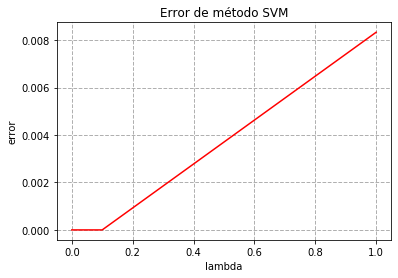

In [17]:
plt.plot(lambdas, error_SVM, color = 'red')
plt.title('Error de método SVM')
plt.xlabel('lambda')
plt.ylabel('error')
#plt.grid()
plt.grid(linestyle='--', linewidth=1)
plt.show()

A continuación se muestran los resultados de función predefinida `SVM`:

In [18]:
theta_SVM, theta_0_SVM = SVM(X = vars_train, Y = labels_train, 
                             theta = np.array([0.0, 0.0, 0.0, 0.0]), theta_0 = np.array([0.0]),
                             etha = 1e-4, lamb = 1e-4)
print('Parámetros del hiperplano SVM: ', theta_SVM)
print('Pseudo-ordenada al origen SVM: ', theta_0_SVM)
error_SVM = error(vars_test, labels_test, theta_SVM, theta_0_SVM)
print('Error de método SVM: ', error_SVM)
print('Jacobiano evaluado en parámetros óptimos SVM: ', jacob(X = vars_train, Y = labels_train, 
                                                          theta = theta_SVM, theta_0 = theta_0_SVM, lamb = 1e-3))

Parámetros del hiperplano SVM:  [  8.34218174  20.85576294 -31.01597078 -14.73339556]
Pseudo-ordenada al origen SVM:  [4.19432833]
Error de método SVM:  0.0
Jacobiano evaluado en parámetros óptimos SVM:  0.02051595861769767


# Perceptrón

Definiendo una clase

In [30]:
class Perceptron:
    #constructor de la clase
    def __init__(self,tasa=0.1, T=10):
        self.tasa = tasa
        self.T = T
    #Función que me calcula el producto punto de 
    #las thetas con el vector de características para una observación(con un 1 agregado)
    def z(self,X):
        z=np.dot(X,self.w[1:])+self.w[0]
        return z
    #clasifica  1 si se encuentra en el semiespacio positivo del hiperplano generado
    #porlas thetas y -1  en el semiespacio negativo
    def predict(self,X):
        clase=np.where(self.z(X)>=0.0,1,-1)
        return clase
    #obtención de thetas
    def perceptron(self,X,y):
        #Graficar
        #se guardan todos los valores de thetas para la grafica de entrenamiento
        self.W=np.zeros(((self.T)*len(X),1 + X.shape[1]))
        #Inicializamos pesos
        self.w = np.zeros(1 + X.shape[1])
        self.w[2]=0.000001
        j=0
        for i in range(self.T):
            for ob,clase in zip(X,y):
                actual=self.tasa*(clase-self.predict(ob))
                self.w[1:]+=actual*ob
                self.w[0]+=actual
                self.W[j,:]=self.w 
                j+=1
        return self

Para poder ver gráficamente como separa los datos nuestro algoritmo, definiremos una función para graficar

In [31]:
#Función para graficar una recta(hiperplano de dos dimensiones).
def grafica_recta(ax,a,b):
    """ DEF: Grafica una recta o hiperplano de dos dimensiones
    Inputs:
    ax: producto entre pendiente y x
    a: pendiente
    b:ordenada
    Outputs:
    grafica de una recta
    """
    x = np.linspace(4,7.5,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = a*x+b
            line.set_ydata(y)
    else: 
        y = a*x+b
        ax.plot(x, y, 'm')
    fig.canvas.draw()

### Prueba del algoritmo: Perceptrón

Para confirmar que tenemos clases separables, graficaremos

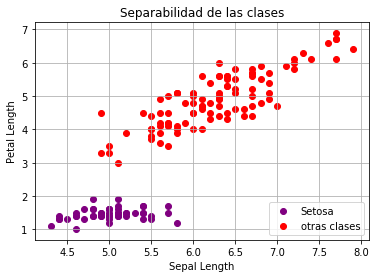

In [21]:
#Para ver separabilidad de clases 
#Definición de X:
X=data.iloc[:149,[0,2]].values
#Definición de y:
y=data.iloc[:149,5].values
#Graficación:
plt.scatter(X[:50, 0], X[:50, 1], color='purple', marker='o', label='Setosa')
plt.scatter(X[50:149, 0], X[50:149, 1], color='red', marker='o', label='otras clases')
plt.grid(True)
plt.title('Separabilidad de las clases')
plt.xlabel('Sepal Length')
plt.ylabel('Petal Length')
plt.legend(loc='lower right')
plt.show()

In [22]:
#dividiendo en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=0)

Implementando el `Perceptrón`

In [25]:
#entrenando con nuestro conjunto de entrenamiento
p=Perceptron(tasa=1,T=10)#iniciando clase
#Aplicar perceptron a X y y
%matplotlib notebook
p.perceptron(X_train,y_train)
print(p.w)
print(p.W[-1,:])
print(p.W.shape)

[  4.        10.6      -20.799999]
[  4.        10.6      -20.799999]
(1190, 3)


# Gráfica animada que muestra los cambios en el hiperplano

<IPython.core.display.Javascript object>


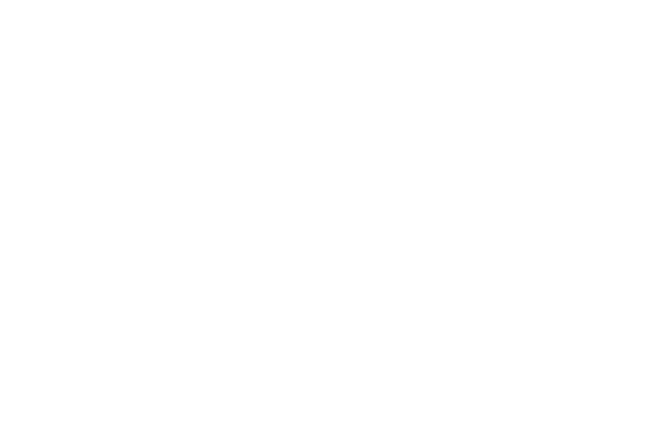

<IPython.core.display.Javascript object>


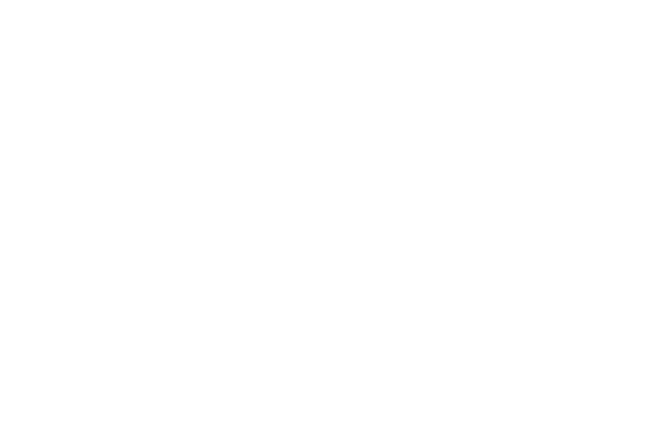

In [26]:
plt.close
#grafica de los cambios en el hiperplano
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Petal Length')
ax.set_xlim(4,8)
ax.set_ylim(0,8)
ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], color='purple', marker='o', label='Setosa')
ax.scatter(X_train[y_train==-1, 0], X_train[y_train==-1, 1], color='red', marker='o', label='otras clases')
ax.grid(True)
for i in range(len(p.W)):
    if i>0 and (not np.array_equal(p.W[i,:],p.W[i-1,:])):
        b0=p.W[i,0]
        b1=p.W[i,1]
        b2=p.W[i,2]
        b=-b0/b2
        a=-b1/b2
        grafica_recta(ax,a,b)
        time.sleep(.80)
    elif i==0:
        b0=p.W[i,0]
        b1=p.W[i,1]
        b2=p.W[i,2]
        b=-b0/b2
        a=-b1/b2
        grafica_recta(ax,a,b)
        time.sleep(.5)

<IPython.core.display.Javascript object>


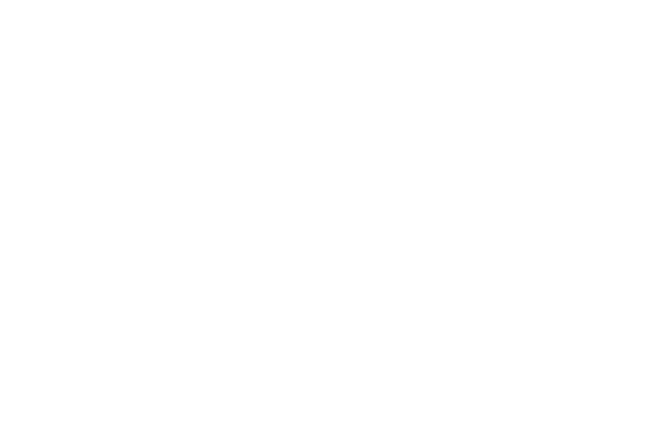

<IPython.core.display.Javascript object>


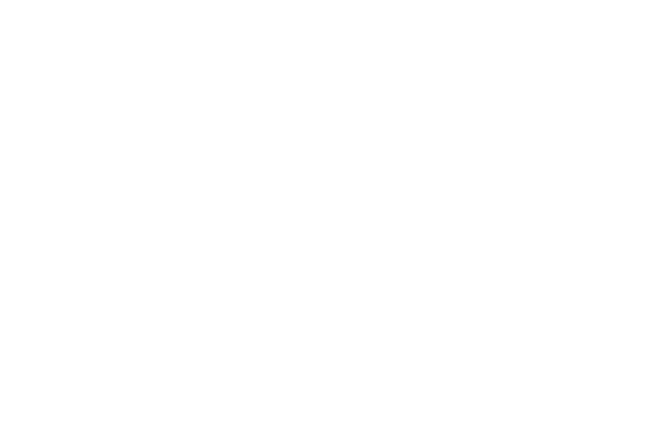

In [27]:
plt.close
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Petal Length')
ax.set_xlim(4,8)
ax.set_ylim(0,9)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='purple', marker='o', label='Setosa')
ax.scatter(X_test[y_test==-1, 0], X_test[y_test==-1, 0], color='red', marker='o', label='Versicolor')
ax.grid(True)
grafica_recta(ax,a,b)
time.sleep(1)

Error y matriz de confusión

In [43]:
#Para ver el error 
y_estimada=p.predict(X_test)
print("Accuracy del modelo:", accuracy_score(y_estimada, y_test))
error=1-accuracy_score(y_estimada, y_test)
print('matriz de confusión: ')
print(confusion_matrix(y_test,y_estimada))  

Accuracy del modelo: 1.0
matriz de confusión: 
[[18  0]
 [ 0 12]]


mostrando las thetas del perceptrón

In [39]:
print("Thetas: " + str(p.w[1:]))
theta_per=p.w[1:]
theta_0_per=p.w[0]

Thetas: [ 10.6      -20.799999]


# Resultados de los 3 algoritmos

In [40]:
print(tabulate([['SGD', theta_SVM, theta_0_SVM, error_SVM], ['SVM', theta_SGD, theta_0_SGD, error_SGD],['Perceptrón',theta_per,theta_0_per,error]], 
               headers=['Método', 'theta', 'theta_0', 'Error']))

Método      theta                                                    theta_0    Error
----------  -----------------------------------------------------  ---------  -------
SGD         [  8.34218174  20.85576294 -31.01597078 -14.73339556]   4.19433         0
SVM         [ 0.74724692  1.71755737 -2.87446804 -1.1700243 ]       0.235794        0
Perceptrón  [ 10.6      -20.799999]                                 4               0
